#### Machine learning proves immensely helpful in many industries in automating tasks that earlier required human labor one such application of ML is predicting whether a particular trade will be profitable or not.
#### In this notebook, we will learn how to predict a signal that indicates whether buying a particular stock will be helpful or not by using ML.
#### Let’s start by importing some libraries which will be used for various purposes which will be explained later in this notebook.

## Importing Libraries
Python libraries make it very easy for us to handle the data and perform typical and complex tasks with a single line of code.

* Pandas – This library helps to load the data frame in a 2D array format and has multiple functions to perform analysis tasks in one go.
* Numpy – Numpy arrays are very fast and can perform large computations in a very short time.
* Matplotlib/Seaborn – This library is used to draw visualizations.
* Sklearn – This module contains multiple libraries having pre-implemented functions to perform tasks from data preprocessing to model development and evaluation.
* XGBoost – This contains the eXtreme Gradient Boosting machine learning algorithm which is one of the algorithms which helps us to achieve high accuracy on predictions.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

## importing dataset

In [3]:
df = pd.read_csv('/kaggle/input/bitcoin-price-prediction-dataset/BTC-USD(1).csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [4]:
df.shape

(2747, 7)

In [5]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2747.000000,2747.000000,2747.000000,2747.000000,2747.000000,2.747000e+03
mean,11668.600272,11981.034949,11325.596907,11682.892098,11682.892098,1.484704e+10
std,16323.683853,16759.568657,15825.584507,16330.191582,16330.191582,1.994819e+10
min,176.897003,211.731003,171.509995,178.102997,178.102997,5.914570e+06
25%,609.122009,611.894501,606.309479,609.234009,609.234009,8.161285e+07
50%,6371.850098,6500.870117,6285.629883,6376.709961,6376.709961,5.227550e+09
75%,10728.271485,10992.468751,10412.890137,10755.395019,10755.395019,2.500517e+10
max,67549.734375,68789.625000,66382.062500,67566.828125,67566.828125,3.509679e+11


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2747 entries, 0 to 2746
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2747 non-null   object 
 1   Open       2747 non-null   float64
 2   High       2747 non-null   float64
 3   Low        2747 non-null   float64
 4   Close      2747 non-null   float64
 5   Adj Close  2747 non-null   float64
 6   Volume     2747 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 150.4+ KB


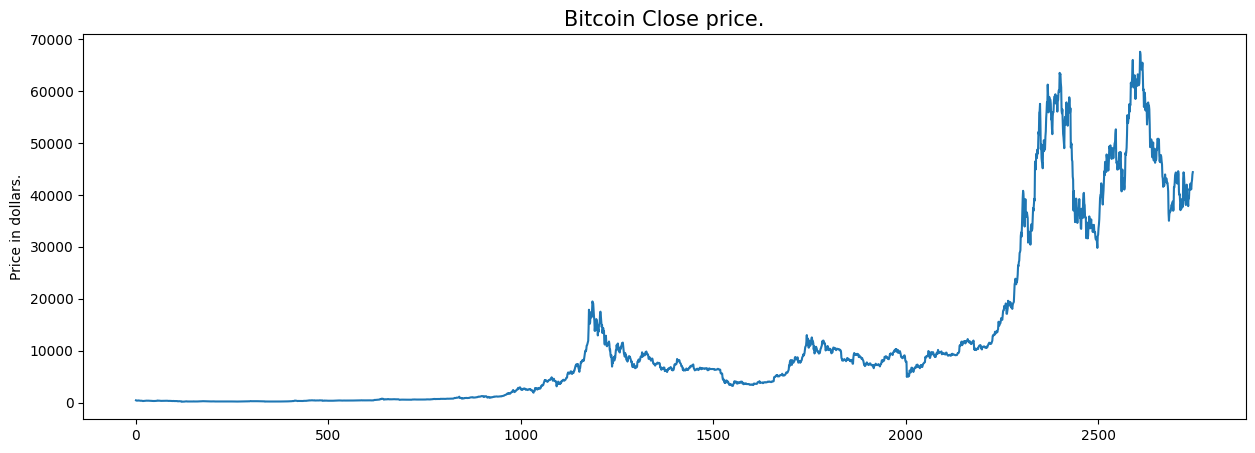

In [7]:
plt.figure(figsize=(15, 5))
plt.plot(df['Close'])
plt.title('Bitcoin Close price.', fontsize=15)
plt.ylabel('Price in dollars.')
plt.show()

In [8]:
df[df['Close'] == df['Adj Close']].shape, df.shape

((2747, 7), (2747, 7))

From here we can conclude that all the rows of columns ‘Close’ and ‘Adj Close’ have the same data. So, having redundant data in the dataset is not going to help so, we’ll drop this column before further analysis.

In [9]:
df = df.drop(['Adj Close'], axis=1)

Now let’s draw the distribution plot for the continuous features given in the dataset but before moving further let’s check for the null values if any are present in the data frame.

In [10]:
df.isnull().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

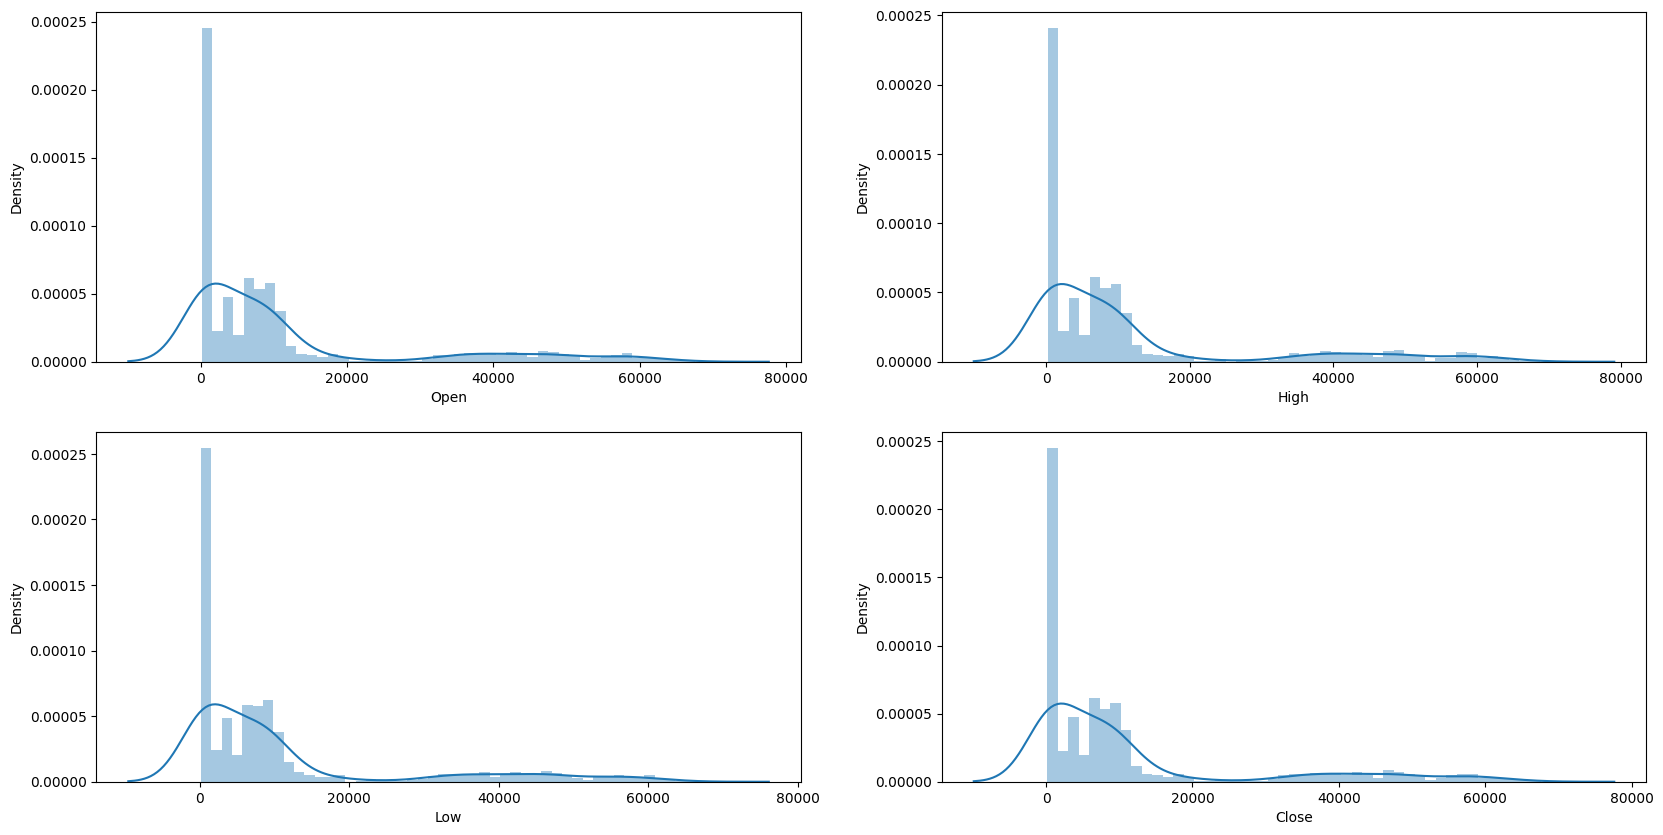

In [11]:
features = ['Open', 'High', 'Low', 'Close']

plt.subplots(figsize=(20,10))
for i, col in enumerate(features):
  plt.subplot(2,2,i+1)
  sb.distplot(df[col])
plt.show()

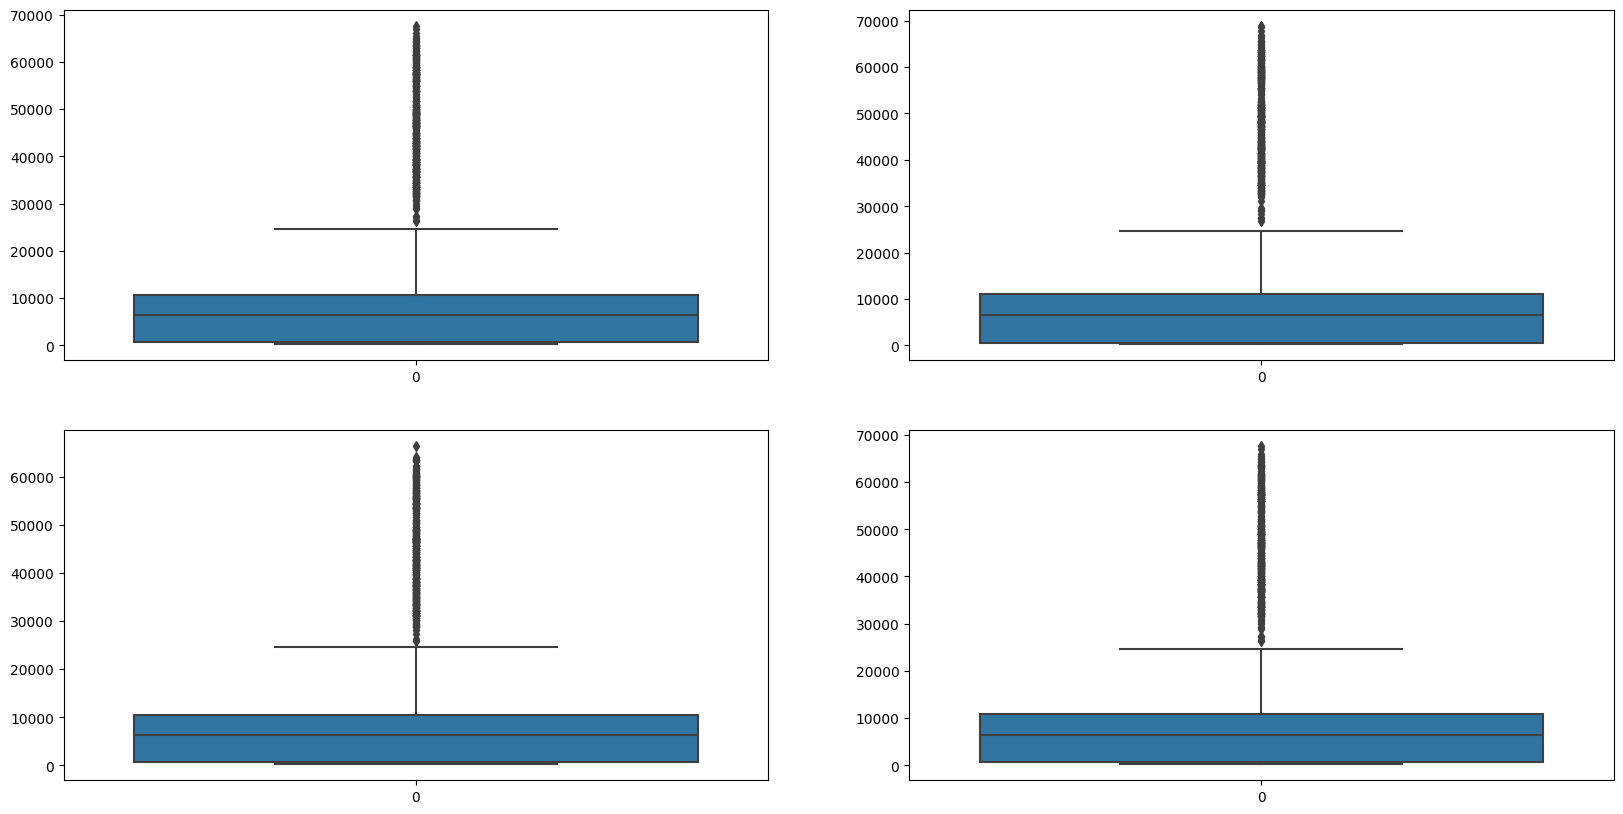

In [12]:
plt.subplots(figsize=(20,10))
for i, col in enumerate(features):
  plt.subplot(2,2,i+1)
  sb.boxplot(df[col])
plt.show()

There are so many outliers in the data which means that the prices of the stock have varied hugely in a very short period of time. Let’s check this with the help of a barplot. 

## Feature Engineering


In [13]:
splitted = df['Date'].str.split('-', expand=True)

df['year'] = splitted[0].astype('int')
df['month'] = splitted[1].astype('int')
df['day'] = splitted[2].astype('int')

# Convert the 'Date' column to datetime objects
df['Date'] = pd.to_datetime(df['Date']) 

df.head()

# This code is modified by Susobhan Akhuli

,Date,Open,High,Low,Close,Volume,year,month,day
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,2014,9,17
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,2014,9,18
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,2014,9,19
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,2014,9,20
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,2014,9,21


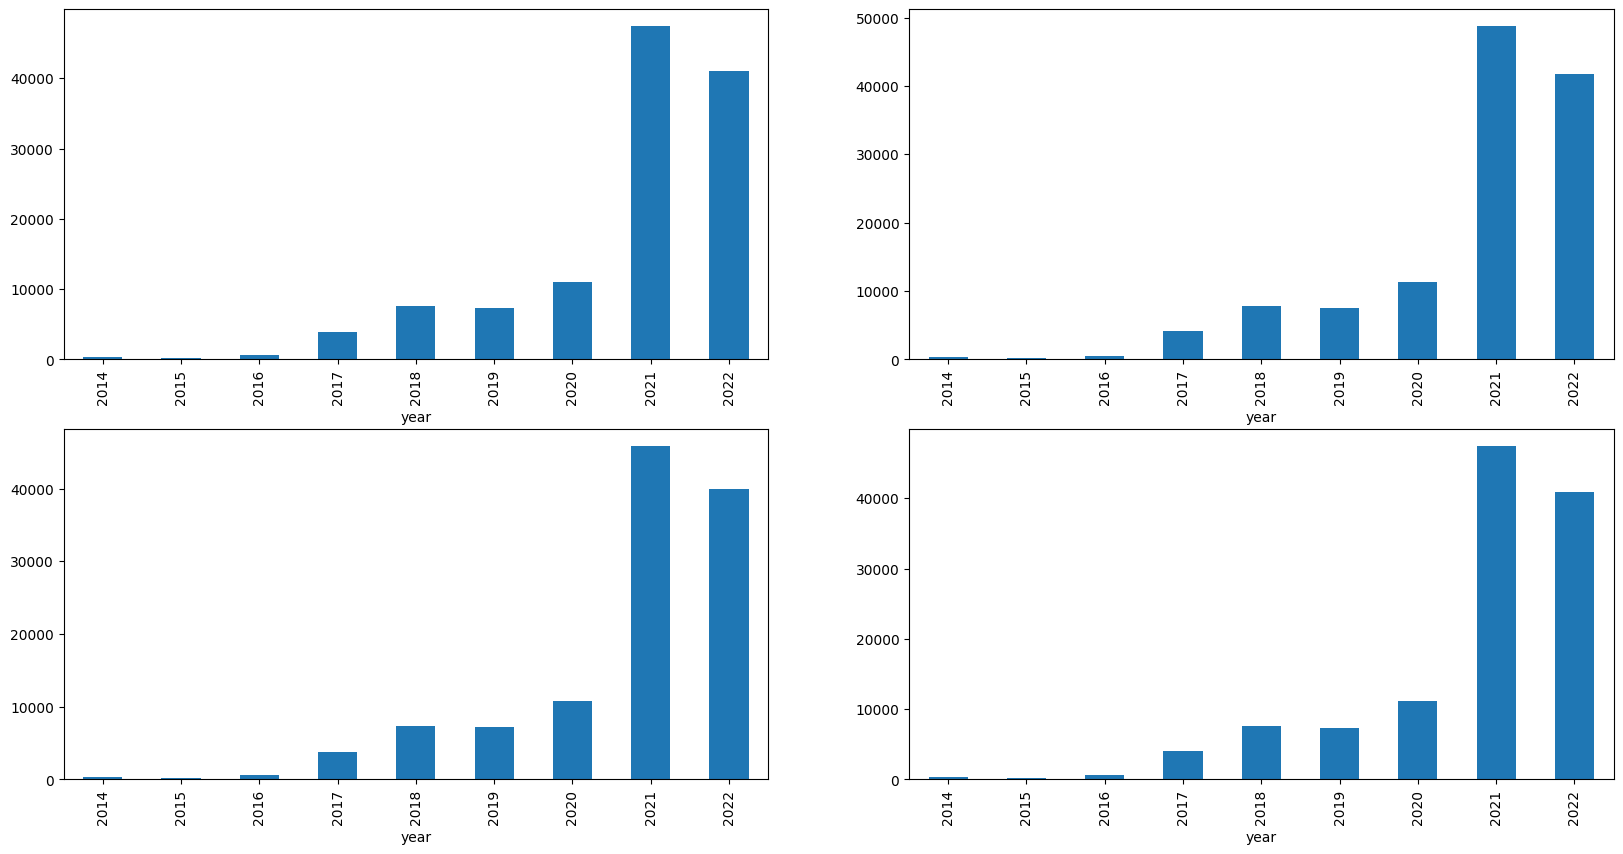

In [14]:
data_grouped = df.groupby('year').mean()
plt.subplots(figsize=(20,10))
for i, col in enumerate(['Open', 'High', 'Low', 'Close']):
  plt.subplot(2,2,i+1)
  data_grouped[col].plot.bar()
plt.show()

In [15]:
df['is_quarter_end'] = np.where(df['month']%3==0,1,0)
df.head()

,Date,Open,High,Low,Close,Volume,year,month,day,is_quarter_end
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,2014,9,17,1
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,2014,9,18,1
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,2014,9,19,1
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,2014,9,20,1
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,2014,9,21,1


In [16]:
df['open-close']  = df['Open'] - df['Close']
df['low-high']  = df['Low'] - df['High']
df['target'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)

Above we have added some more columns which will help in the training of our model. We have added the target feature which is a signal whether to buy or not we will train our model to predict this only. But before proceeding let’s check whether the target is balanced or not using a pie chart.

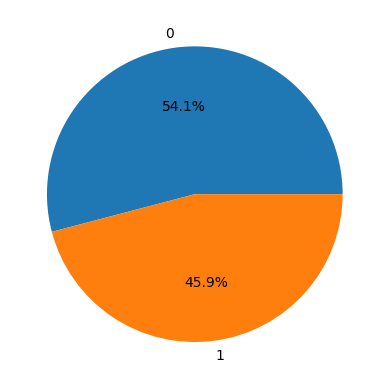

In [17]:
plt.pie(df['target'].value_counts().values, 
        labels=[0, 1], autopct='%1.1f%%')
plt.show()

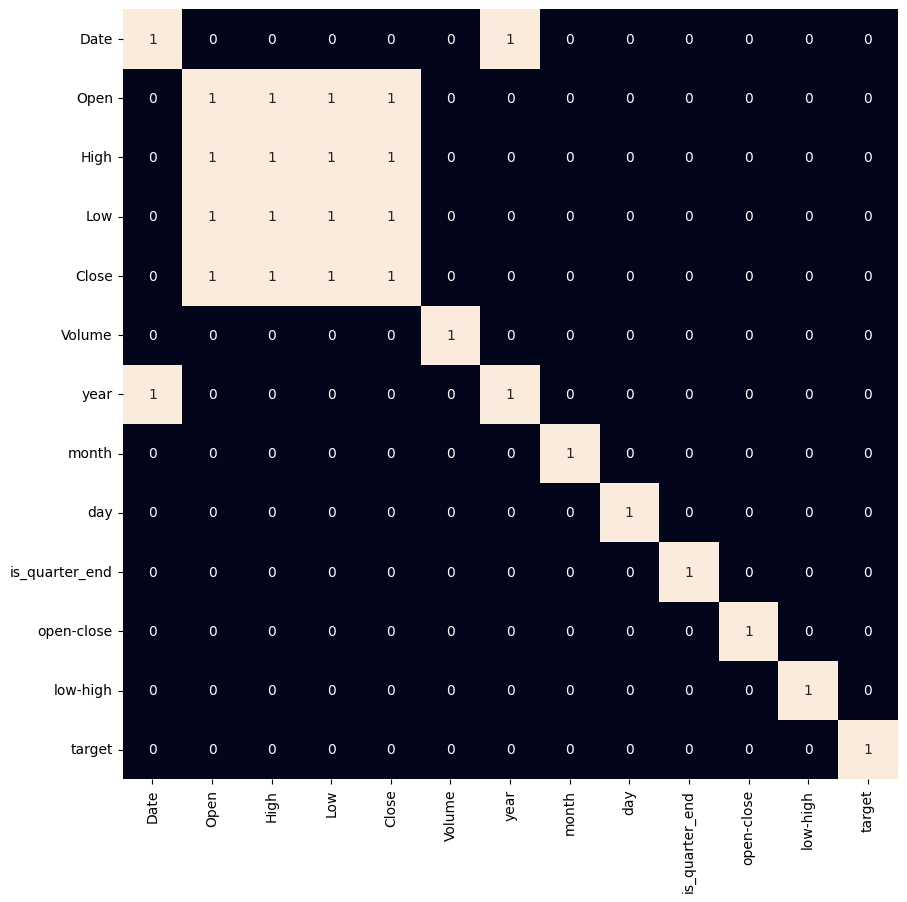

In [18]:
plt.figure(figsize=(10, 10))

# As our concern is with the highly
# correlated features only so, we will visualize
# our heatmap as per that criteria only.
sb.heatmap(df.corr() > 0.9, annot=True, cbar=False)
plt.show()

In [20]:
features = df[['open-close', 'low-high', 'is_quarter_end']]
target = df['target']

scaler = StandardScaler()
features = scaler.fit_transform(features)
#We do not use train test split, rather use the first 70% data to train and last 30% to test
X_train, X_valid, Y_train, Y_valid = X_train, X_valid, Y_train, Y_valid = features[:len(features)//7],features[len(features)//7:],target[:len(features)//7],target[len(features)//7:]

## Model Development and Evaluation

In [21]:
models = [LogisticRegression(), SVC(kernel='poly', probability=True), XGBClassifier()]

for i in range(3):
  models[i].fit(X_train, Y_train)

  print(f'{models[i]} : ')
  print('Training Accuracy : ', metrics.roc_auc_score(Y_train, models[i].predict_proba(X_train)[:,1]))
  print('Validation Accuracy : ', metrics.roc_auc_score(Y_valid, models[i].predict_proba(X_valid)[:,1]))
  print()

LogisticRegression() : 
Training Accuracy :  0.5316999505298513
Validation Accuracy :  0.5173657081518185

SVC(kernel='poly', probability=True) : 
Training Accuracy :  0.4698622646913323
Validation Accuracy :  0.4891724671307038

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) : 
Training 

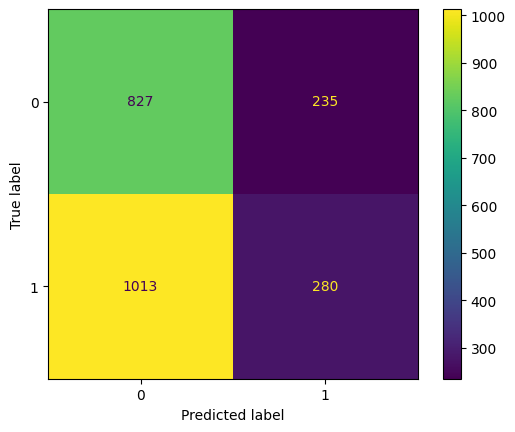

In [22]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(models[0], X_valid, Y_valid)
plt.show()


## Conclusion:
We can observe that the accuracy achieved by the state-of-the-art ML model is no better than simply guessing with a probability of 50%. Possible reasons for this may be the lack of data or using a very simple model to perform such a complex task as Stock Market prediction.